In [1]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = 'C:/Users/jjh02/바탕 화면/Experiment/CelebA_Dataset/CelebA/Img'
all_images_dir = os.path.join(DATA_DIR, 'img_align_celeba')

print(len(os.listdir(all_images_dir)))

202599


In [3]:
print(os.listdir(all_images_dir)[:10])

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


In [4]:
if not os.path.exists(all_images_dir):
    os.makedirs(all_images_dir)
    for img_file in os.listdir(DATA_DIR):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
            shutil.move(os.path.join(DATA_DIR, img_file), os.path.join(all_images_dir, img_file))

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 

In [6]:
train_ds = ImageFolder(root=DATA_DIR, transform=T.Compose([
                        T.Resize(image_size), 
                        T.CenterCrop(image_size), 
                        T.ToTensor(), 
                        T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [7]:
print("Number of images:", len(train_ds))

Number of images: 202599


In [8]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

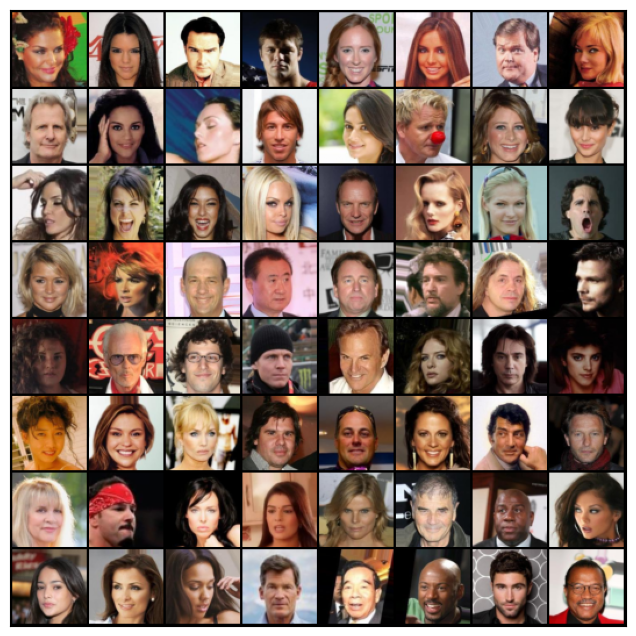

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()


In [13]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [14]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


Generator Network

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

In [19]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


torch.Size([128, 3, 64, 64])


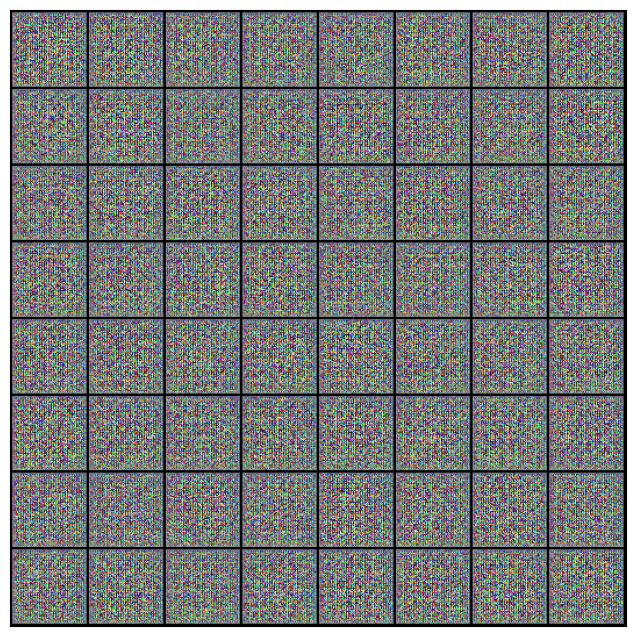

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

Training Discriminator

In [22]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

Generator Training

In [23]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999689..0.9998955].


Saving generated=images-0000.png


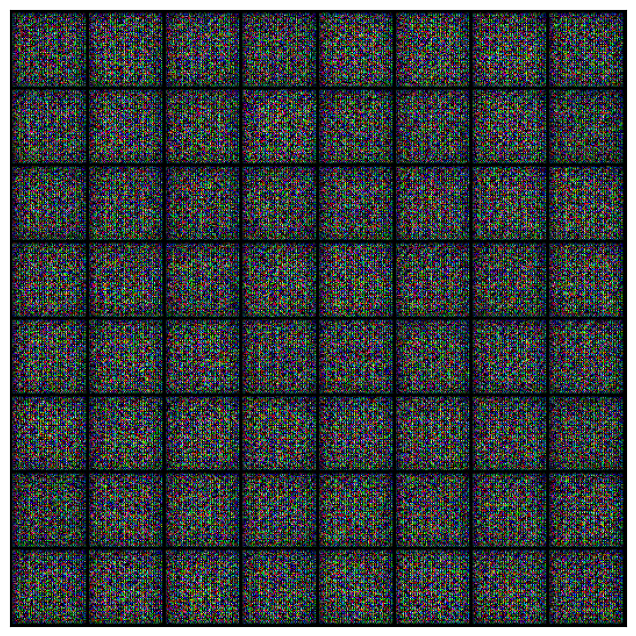

In [28]:
save_samples(0, fixed_latent)

Training Loop

In [34]:
import sys
from tqdm import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    start_time = time.time()

    for epoch in range(epochs):
        progress_bar = tqdm(total=len(train_dl), desc=f"Epoch [{epoch+1}/{epochs}]", unit="batch")
        for i, (real_images, _) in enumerate(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

            progress_bar.set_postfix(loss_g=loss_g, loss_d=loss_d, real_score=real_score, fake_score=fake_score)
            progress_bar.update()

        progress_bar.close()

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log end of epoch
        print(f"Epoch [{epoch+1}/{epochs}] completed, loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
        sys.stdout.flush()  # 출력 버퍼를 비웁니다
        save_samples(epoch + start_idx, fixed_latent, show=False)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Training Duration: {elapsed_time:.4f} seconds")

    return losses_g, losses_d, real_scores, fake_scores

In [36]:
# Hyperparameters
lr = 0.00025
epochs = 60

In [37]:
history = fit(epochs, lr)

Epoch [1/60]: 100%|██████████| 1583/1583 [06:39<00:00,  3.97batch/s, fake_score=0.0253, loss_d=0.628, loss_g=2.05, real_score=0.594]    

Epoch [1/60] completed, loss_g: 2.0524, loss_d: 0.6284, real_score: 0.5941, fake_score: 0.0253


Saving generated=images-0001.png


Epoch [2/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.98batch/s, fake_score=0.411, loss_d=0.677, loss_g=6.08, real_score=0.937]   

Epoch [2/60] completed, loss_g: 6.0813, loss_d: 0.6766, real_score: 0.9374, fake_score: 0.4113


Saving generated=images-0002.png


Epoch [3/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.121, loss_d=0.184, loss_g=3.91, real_score=0.959]   

Epoch [3/60] completed, loss_g: 3.9057, loss_d: 0.1836, real_score: 0.9591, fake_score: 0.1210


Saving generated=images-0003.png


Epoch [4/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.98batch/s, fake_score=0.0915, loss_d=0.179, loss_g=3.43, real_score=0.938]   

Epoch [4/60] completed, loss_g: 3.4302, loss_d: 0.1792, real_score: 0.9379, fake_score: 0.0915


Saving generated=images-0004.png


Epoch [5/60]: 100%|██████████| 1583/1583 [06:40<00:00,  3.95batch/s, fake_score=0.0213, loss_d=0.176, loss_g=2.96, real_score=0.867]   

Epoch [5/60] completed, loss_g: 2.9634, loss_d: 0.1760, real_score: 0.8669, fake_score: 0.0213


Saving generated=images-0005.png


Epoch [6/60]: 100%|██████████| 1583/1583 [06:42<00:00,  3.94batch/s, fake_score=0.243, loss_d=0.425, loss_g=4.67, real_score=0.905]    

Epoch [6/60] completed, loss_g: 4.6702, loss_d: 0.4245, real_score: 0.9047, fake_score: 0.2430


Saving generated=images-0006.png


Epoch [7/60]: 100%|██████████| 1583/1583 [06:38<00:00,  3.97batch/s, fake_score=0.162, loss_d=0.273, loss_g=4.33, real_score=0.933]   

Epoch [7/60] completed, loss_g: 4.3256, loss_d: 0.2733, real_score: 0.9333, fake_score: 0.1623


Saving generated=images-0007.png


Epoch [8/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.106, loss_d=0.188, loss_g=3.97, real_score=0.938]    

Epoch [8/60] completed, loss_g: 3.9729, loss_d: 0.1877, real_score: 0.9380, fake_score: 0.1060


Saving generated=images-0008.png


Epoch [9/60]: 100%|██████████| 1583/1583 [06:39<00:00,  3.96batch/s, fake_score=0.0018, loss_d=0.555, loss_g=3.76, real_score=0.642]   

Epoch [9/60] completed, loss_g: 3.7568, loss_d: 0.5551, real_score: 0.6423, fake_score: 0.0018


Saving generated=images-0009.png


Epoch [10/60]: 100%|██████████| 1583/1583 [06:40<00:00,  3.95batch/s, fake_score=0.0498, loss_d=0.223, loss_g=3.55, real_score=0.868]   

Epoch [10/60] completed, loss_g: 3.5488, loss_d: 0.2231, real_score: 0.8684, fake_score: 0.0498


Saving generated=images-0010.png


Epoch [11/60]: 100%|██████████| 1583/1583 [06:38<00:00,  3.97batch/s, fake_score=0.0377, loss_d=0.0952, loss_g=3.41, real_score=0.949]  

Epoch [11/60] completed, loss_g: 3.4122, loss_d: 0.0952, real_score: 0.9491, fake_score: 0.0377


Saving generated=images-0011.png


Epoch [12/60]: 100%|██████████| 1583/1583 [06:42<00:00,  3.94batch/s, fake_score=0.0753, loss_d=0.138, loss_g=4.12, real_score=0.95]    

Epoch [12/60] completed, loss_g: 4.1163, loss_d: 0.1378, real_score: 0.9500, fake_score: 0.0753


Saving generated=images-0012.png


Epoch [13/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.98batch/s, fake_score=0.233, loss_d=0.329, loss_g=5.75, real_score=0.99]    

Epoch [13/60] completed, loss_g: 5.7458, loss_d: 0.3292, real_score: 0.9903, fake_score: 0.2335


Saving generated=images-0013.png


Epoch [14/60]: 100%|██████████| 1583/1583 [06:34<00:00,  4.01batch/s, fake_score=0.0201, loss_d=0.187, loss_g=2.43, real_score=0.866]    

Epoch [14/60] completed, loss_g: 2.4330, loss_d: 0.1873, real_score: 0.8663, fake_score: 0.0201


Saving generated=images-0014.png


Epoch [15/60]: 100%|██████████| 1583/1583 [06:40<00:00,  3.95batch/s, fake_score=0.207, loss_d=0.372, loss_g=4.67, real_score=0.919]    

Epoch [15/60] completed, loss_g: 4.6738, loss_d: 0.3723, real_score: 0.9190, fake_score: 0.2068


Saving generated=images-0015.png


Epoch [16/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0664, loss_d=0.0901, loss_g=5.37, real_score=0.987]  

Epoch [16/60] completed, loss_g: 5.3660, loss_d: 0.0901, real_score: 0.9868, fake_score: 0.0664


Saving generated=images-0016.png


Epoch [17/60]: 100%|██████████| 1583/1583 [06:34<00:00,  4.01batch/s, fake_score=0.0306, loss_d=0.128, loss_g=3.41, real_score=0.92]     

Epoch [17/60] completed, loss_g: 3.4055, loss_d: 0.1279, real_score: 0.9196, fake_score: 0.0306


Saving generated=images-0017.png


Epoch [18/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0594, loss_d=0.115, loss_g=3.19, real_score=0.957]  

Epoch [18/60] completed, loss_g: 3.1939, loss_d: 0.1151, real_score: 0.9574, fake_score: 0.0594


Saving generated=images-0018.png


Epoch [19/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.99batch/s, fake_score=0.0379, loss_d=0.0796, loss_g=4.96, real_score=0.969]  

Epoch [19/60] completed, loss_g: 4.9650, loss_d: 0.0796, real_score: 0.9686, fake_score: 0.0379


Saving generated=images-0019.png


Epoch [20/60]: 100%|██████████| 1583/1583 [06:39<00:00,  3.96batch/s, fake_score=0.0465, loss_d=0.218, loss_g=5.04, real_score=0.874]   

Epoch [20/60] completed, loss_g: 5.0405, loss_d: 0.2183, real_score: 0.8735, fake_score: 0.0465


Saving generated=images-0020.png


Epoch [21/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.01batch/s, fake_score=0.129, loss_d=0.389, loss_g=2.19, real_score=0.826]      

Epoch [21/60] completed, loss_g: 2.1896, loss_d: 0.3886, real_score: 0.8261, fake_score: 0.1290


Saving generated=images-0021.png


Epoch [22/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0663, loss_d=0.0894, loss_g=5.12, real_score=0.987]  

Epoch [22/60] completed, loss_g: 5.1158, loss_d: 0.0894, real_score: 0.9871, fake_score: 0.0663


Saving generated=images-0022.png


Epoch [23/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0131, loss_d=0.0379, loss_g=5.64, real_score=0.977]  

Epoch [23/60] completed, loss_g: 5.6428, loss_d: 0.0379, real_score: 0.9768, fake_score: 0.0131


Saving generated=images-0023.png


Epoch [24/60]: 100%|██████████| 1583/1583 [06:39<00:00,  3.97batch/s, fake_score=0.241, loss_d=0.412, loss_g=2.55, real_score=0.979]    

Epoch [24/60] completed, loss_g: 2.5513, loss_d: 0.4117, real_score: 0.9787, fake_score: 0.2406


Saving generated=images-0024.png


Epoch [25/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.01batch/s, fake_score=0.0439, loss_d=0.166, loss_g=3.8, real_score=0.915]    

Epoch [25/60] completed, loss_g: 3.7987, loss_d: 0.1657, real_score: 0.9153, fake_score: 0.0439


Saving generated=images-0025.png


Epoch [26/60]: 100%|██████████| 1583/1583 [06:32<00:00,  4.04batch/s, fake_score=0.00836, loss_d=0.225, loss_g=2.34, real_score=0.834]   

Epoch [26/60] completed, loss_g: 2.3366, loss_d: 0.2249, real_score: 0.8336, fake_score: 0.0084


Saving generated=images-0026.png


Epoch [27/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0708, loss_d=0.0871, loss_g=4.68, real_score=0.998]  

Epoch [27/60] completed, loss_g: 4.6794, loss_d: 0.0871, real_score: 0.9976, fake_score: 0.0708


Saving generated=images-0027.png


Epoch [28/60]: 100%|██████████| 1583/1583 [06:39<00:00,  3.96batch/s, fake_score=0.0235, loss_d=0.0922, loss_g=4.54, real_score=0.94]  

Epoch [28/60] completed, loss_g: 4.5350, loss_d: 0.0922, real_score: 0.9396, fake_score: 0.0235


Saving generated=images-0028.png


Epoch [29/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.00595, loss_d=0.305, loss_g=2.55, real_score=0.78]   

Epoch [29/60] completed, loss_g: 2.5467, loss_d: 0.3049, real_score: 0.7797, fake_score: 0.0060


Saving generated=images-0029.png


Epoch [30/60]: 100%|██████████| 1583/1583 [06:36<00:00,  4.00batch/s, fake_score=0.129, loss_d=0.192, loss_g=5.19, real_score=0.976]    

Epoch [30/60] completed, loss_g: 5.1941, loss_d: 0.1925, real_score: 0.9763, fake_score: 0.1288


Saving generated=images-0030.png


Epoch [31/60]: 100%|██████████| 1583/1583 [06:36<00:00,  4.00batch/s, fake_score=0.101, loss_d=0.155, loss_g=6.06, real_score=0.973]    

Epoch [31/60] completed, loss_g: 6.0598, loss_d: 0.1546, real_score: 0.9729, fake_score: 0.1008


Saving generated=images-0031.png


Epoch [32/60]: 100%|██████████| 1583/1583 [06:36<00:00,  4.00batch/s, fake_score=0.0879, loss_d=0.118, loss_g=6.73, real_score=0.99]   

Epoch [32/60] completed, loss_g: 6.7293, loss_d: 0.1177, real_score: 0.9896, fake_score: 0.0879


Saving generated=images-0032.png


Epoch [33/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0141, loss_d=0.0574, loss_g=5.22, real_score=0.961]  

Epoch [33/60] completed, loss_g: 5.2168, loss_d: 0.0574, real_score: 0.9609, fake_score: 0.0141


Saving generated=images-0033.png


Epoch [34/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0179, loss_d=0.0383, loss_g=5.15, real_score=0.981] 

Epoch [34/60] completed, loss_g: 5.1517, loss_d: 0.0383, real_score: 0.9807, fake_score: 0.0179


Saving generated=images-0034.png


Epoch [35/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0103, loss_d=0.112, loss_g=3.38, real_score=0.911]  

Epoch [35/60] completed, loss_g: 3.3791, loss_d: 0.1125, real_score: 0.9113, fake_score: 0.0103


Saving generated=images-0035.png


Epoch [36/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0105, loss_d=0.0319, loss_g=4.65, real_score=0.981]  

Epoch [36/60] completed, loss_g: 4.6534, loss_d: 0.0319, real_score: 0.9810, fake_score: 0.0105


Saving generated=images-0036.png


Epoch [37/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0145, loss_d=0.0357, loss_g=5.37, real_score=0.981]  

Epoch [37/60] completed, loss_g: 5.3750, loss_d: 0.0357, real_score: 0.9812, fake_score: 0.0145


Saving generated=images-0037.png


Epoch [38/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0305, loss_d=0.0494, loss_g=6.07, real_score=0.984] 

Epoch [38/60] completed, loss_g: 6.0740, loss_d: 0.0494, real_score: 0.9842, fake_score: 0.0305


Saving generated=images-0038.png


Epoch [39/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0452, loss_d=0.075, loss_g=4.37, real_score=0.979]   

Epoch [39/60] completed, loss_g: 4.3669, loss_d: 0.0750, real_score: 0.9788, fake_score: 0.0452


Saving generated=images-0039.png


Epoch [40/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0268, loss_d=0.0409, loss_g=4.83, real_score=0.988]  

Epoch [40/60] completed, loss_g: 4.8327, loss_d: 0.0409, real_score: 0.9880, fake_score: 0.0268


Saving generated=images-0040.png


Epoch [41/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0103, loss_d=0.0637, loss_g=4.62, real_score=0.955]   

Epoch [41/60] completed, loss_g: 4.6212, loss_d: 0.0637, real_score: 0.9548, fake_score: 0.0103


Saving generated=images-0041.png


Epoch [42/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0125, loss_d=0.273, loss_g=3.35, real_score=0.832]   

Epoch [42/60] completed, loss_g: 3.3516, loss_d: 0.2732, real_score: 0.8323, fake_score: 0.0125


Saving generated=images-0042.png


Epoch [43/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0136, loss_d=0.0622, loss_g=5.22, real_score=0.961]  

Epoch [43/60] completed, loss_g: 5.2188, loss_d: 0.0622, real_score: 0.9612, fake_score: 0.0136


Saving generated=images-0043.png


Epoch [44/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.00batch/s, fake_score=0.0585, loss_d=0.102, loss_g=5.64, real_score=0.969]   

Epoch [44/60] completed, loss_g: 5.6395, loss_d: 0.1025, real_score: 0.9690, fake_score: 0.0585


Saving generated=images-0044.png


Epoch [45/60]: 100%|██████████| 1583/1583 [06:33<00:00,  4.03batch/s, fake_score=0.0103, loss_d=0.0503, loss_g=3.89, real_score=0.964] 

Epoch [45/60] completed, loss_g: 3.8855, loss_d: 0.0503, real_score: 0.9637, fake_score: 0.0103


Saving generated=images-0045.png


Epoch [46/60]: 100%|██████████| 1583/1583 [06:29<00:00,  4.07batch/s, fake_score=0.0808, loss_d=0.271, loss_g=4.73, real_score=0.903]   

Epoch [46/60] completed, loss_g: 4.7265, loss_d: 0.2706, real_score: 0.9031, fake_score: 0.0808


Saving generated=images-0046.png


Epoch [47/60]: 100%|██████████| 1583/1583 [06:29<00:00,  4.06batch/s, fake_score=0.0689, loss_d=0.0951, loss_g=6.1, real_score=0.996]  

Epoch [47/60] completed, loss_g: 6.0963, loss_d: 0.0951, real_score: 0.9960, fake_score: 0.0689


Saving generated=images-0047.png


Epoch [48/60]: 100%|██████████| 1583/1583 [06:29<00:00,  4.06batch/s, fake_score=0.00855, loss_d=0.019, loss_g=7.13, real_score=0.99]   

Epoch [48/60] completed, loss_g: 7.1281, loss_d: 0.0190, real_score: 0.9900, fake_score: 0.0086


Saving generated=images-0048.png


Epoch [49/60]: 100%|██████████| 1583/1583 [06:31<00:00,  4.05batch/s, fake_score=0.0162, loss_d=0.295, loss_g=3.98, real_score=0.814]   

Epoch [49/60] completed, loss_g: 3.9813, loss_d: 0.2953, real_score: 0.8141, fake_score: 0.0162


Saving generated=images-0049.png


Epoch [50/60]: 100%|██████████| 1583/1583 [06:35<00:00,  4.01batch/s, fake_score=0.0124, loss_d=0.0188, loss_g=5.91, real_score=0.994]   

Epoch [50/60] completed, loss_g: 5.9071, loss_d: 0.0188, real_score: 0.9943, fake_score: 0.0124


Saving generated=images-0050.png


Epoch [51/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0224, loss_d=0.0285, loss_g=7.08, real_score=0.996]  

Epoch [51/60] completed, loss_g: 7.0813, loss_d: 0.0285, real_score: 0.9957, fake_score: 0.0224


Saving generated=images-0051.png


Epoch [52/60]: 100%|██████████| 1583/1583 [06:36<00:00,  3.99batch/s, fake_score=0.0289, loss_d=0.0714, loss_g=3.98, real_score=0.964]  

Epoch [52/60] completed, loss_g: 3.9836, loss_d: 0.0714, real_score: 0.9637, fake_score: 0.0289


Saving generated=images-0052.png


Epoch [53/60]: 100%|██████████| 1583/1583 [06:36<00:00,  4.00batch/s, fake_score=0.233, loss_d=0.483, loss_g=4.69, real_score=0.943]    

Epoch [53/60] completed, loss_g: 4.6913, loss_d: 0.4831, real_score: 0.9428, fake_score: 0.2327


Saving generated=images-0053.png


Epoch [54/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.99batch/s, fake_score=0.0471, loss_d=0.0563, loss_g=4.82, real_score=0.997]  

Epoch [54/60] completed, loss_g: 4.8225, loss_d: 0.0563, real_score: 0.9968, fake_score: 0.0471


Saving generated=images-0054.png


Epoch [55/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.98batch/s, fake_score=0.0508, loss_d=0.0807, loss_g=7.3, real_score=0.982]   

Epoch [55/60] completed, loss_g: 7.3039, loss_d: 0.0807, real_score: 0.9817, fake_score: 0.0508


Saving generated=images-0055.png


Epoch [56/60]: 100%|██████████| 1583/1583 [06:37<00:00,  3.98batch/s, fake_score=0.0442, loss_d=0.0668, loss_g=6.59, real_score=0.993]  

Epoch [56/60] completed, loss_g: 6.5897, loss_d: 0.0668, real_score: 0.9926, fake_score: 0.0442


Saving generated=images-0056.png


Epoch [57/60]: 100%|██████████| 1583/1583 [06:38<00:00,  3.98batch/s, fake_score=0.0392, loss_d=0.104, loss_g=5.66, real_score=0.954]   

Epoch [57/60] completed, loss_g: 5.6593, loss_d: 0.1042, real_score: 0.9537, fake_score: 0.0392


Saving generated=images-0057.png


Epoch [58/60]: 100%|██████████| 1583/1583 [06:38<00:00,  3.98batch/s, fake_score=0.0144, loss_d=0.106, loss_g=4.76, real_score=0.929]   

Epoch [58/60] completed, loss_g: 4.7629, loss_d: 0.1063, real_score: 0.9294, fake_score: 0.0144


Saving generated=images-0058.png


Epoch [59/60]: 100%|██████████| 1583/1583 [06:46<00:00,  3.90batch/s, fake_score=0.0691, loss_d=0.108, loss_g=7.61, real_score=0.978]   

Epoch [59/60] completed, loss_g: 7.6073, loss_d: 0.1079, real_score: 0.9775, fake_score: 0.0691


Saving generated=images-0059.png


Epoch [60/60]: 100%|██████████| 1583/1583 [06:38<00:00,  3.97batch/s, fake_score=0.00197, loss_d=0.126, loss_g=6.2, real_score=0.907]   

Epoch [60/60] completed, loss_g: 6.1969, loss_d: 0.1261, real_score: 0.9067, fake_score: 0.0020


Saving generated=images-0060.png
Training Duration: 23810.4166 seconds


In [38]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [40]:
from IPython.display import Image

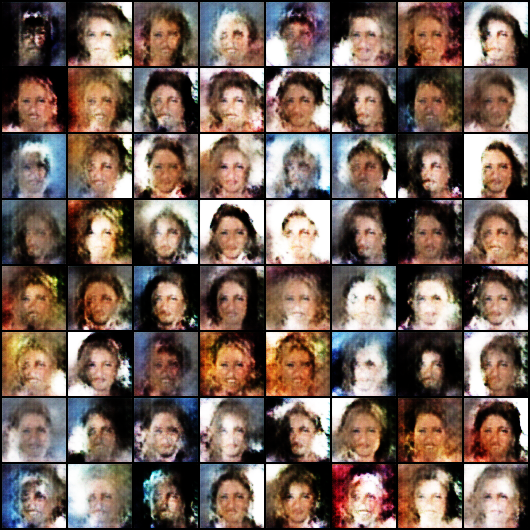

In [41]:
Image('./generated/generated=images-0001.png')

In [43]:
import cv2
import os

vid_fname = 'gans_training.mp4'  # Save as MP4

print("Starting converting images to video.")
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

print(files)

# Use the FourCC code for MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(vid_fname, fourcc, 1.0, (640, 480))

[out.write(cv2.imread(fname)) for fname in files]

out.release()
print("DONE!")

Starting converting images to video.
['generated\\generated=images-0000.png', 'generated\\generated=images-0001.png', 'generated\\generated=images-0002.png', 'generated\\generated=images-0003.png', 'generated\\generated=images-0004.png', 'generated\\generated=images-0005.png', 'generated\\generated=images-0006.png', 'generated\\generated=images-0007.png', 'generated\\generated=images-0008.png', 'generated\\generated=images-0009.png', 'generated\\generated=images-0010.png', 'generated\\generated=images-0011.png', 'generated\\generated=images-0012.png', 'generated\\generated=images-0013.png', 'generated\\generated=images-0014.png', 'generated\\generated=images-0015.png', 'generated\\generated=images-0016.png', 'generated\\generated=images-0017.png', 'generated\\generated=images-0018.png', 'generated\\generated=images-0019.png', 'generated\\generated=images-0020.png', 'generated\\generated=images-0021.png', 'generated\\generated=images-0022.png', 'generated\\generated=images-0023.png', 'g

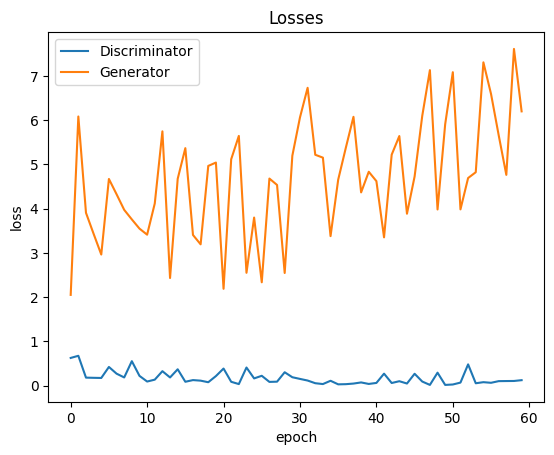

In [44]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

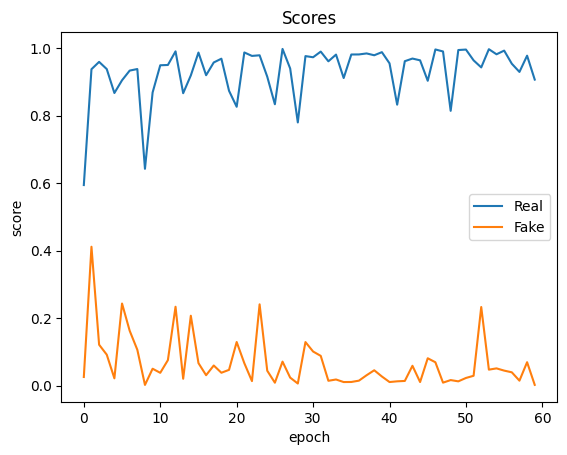

In [45]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');